In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

## N-Gram Language Modeling

In [2]:
CONTEXT_SIZE = 2
EMBEDDING_DIM = 10
# We will use Shakespeare Sonnet 2
test_sentence = """When forty winters shall besiege thy brow,
And dig deep trenches in thy beauty's field,
Thy youth's proud livery so gazed on now,
Will be a totter'd weed of small worth held:
Then being asked, where all thy beauty lies,
Where all the treasure of thy lusty days;
To say, within thine own deep sunken eyes,
Were an all-eating shame, and thriftless praise.
How much more praise deserv'd thy beauty's use,
If thou couldst answer 'This fair child of mine
Shall sum my count, and make my old excuse,'
Proving his beauty by succession thine!
This were to be new made when thou art old,
And see thy blood warm when thou feel'st it cold.""".split()

##  Computing Word Embeddings: Continuous Bag-of-Words

In [3]:
CONTEXT_SIZE = 2  # 2 words to the left, 2 to the right
EMBEDDING_DIM = 10
raw_text = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells.""".split()

# By deriving a set from `raw_text`, we deduplicate the array
vocab = set(raw_text)
vocab_size = len(vocab)

In [4]:
vocab_size

49

In [5]:
word_to_ix = {word: i for i, word in enumerate(vocab)}

data = []
for i in range(2, len(raw_text) - 2):
    context = [raw_text[i - 2], raw_text[i - 1],
               raw_text[i + 1], raw_text[i + 2]]
    target = raw_text[i]
    data.append((context, target))
print(data[:5])

[(['We', 'are', 'to', 'study'], 'about'), (['are', 'about', 'study', 'the'], 'to'), (['about', 'to', 'the', 'idea'], 'study'), (['to', 'study', 'idea', 'of'], 'the'), (['study', 'the', 'of', 'a'], 'idea')]


In [6]:
def make_context_vector(context, word_to_ix):
    idxs = [word_to_ix[w] for w in context]
    return torch.tensor(idxs, dtype=torch.long)


make_context_vector(data[0][0], word_to_ix)  # example

tensor([39, 32, 21, 22])

In [7]:
class CBOW(nn.Module):

    def __init__(self, vocab_size, EMBEDDING_DIM):
        super(CBOW, self).__init__()
        self.embedding = nn.Embedding(vocab_size, EMBEDDING_DIM)
        self.linear1 = nn.Linear(EMBEDDING_DIM, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        emds = sum(self.embedding(inputs)).view(1,-1)
        s = F.relu(self.linear1(emds))
        s = self.linear2(s)
        s = F.log_softmax(s, dim=1)
        return s
      


In [8]:
cbow = CBOW(vocab_size, EMBEDDING_DIM)

In [10]:
for data in cbow.named_parameters():
    print(data)

('embedding.weight', Parameter containing:
tensor([[-5.2978e-01,  1.1351e+00, -2.4524e-01,  7.9533e-01, -2.2230e+00,
         -1.1651e-01,  4.7438e-02, -1.5967e+00, -2.4181e+00,  7.6445e-01],
        [ 8.0843e-01, -7.6486e-01, -1.1174e+00, -1.0131e+00, -6.4657e-01,
         -1.0343e+00, -4.2202e-02,  9.9513e-01,  1.7726e+00,  1.4099e+00],
        [-8.5634e-01, -1.3563e+00, -7.5221e-01,  2.0607e-01, -5.6768e-01,
         -1.5189e+00, -1.1806e+00,  4.8861e-01, -2.1318e+00,  1.2338e+00],
        [-7.8642e-01, -2.6068e+00,  7.7416e-01,  6.9042e-01, -2.0834e-01,
          1.2575e+00,  5.0757e-01,  8.5908e-01,  6.0371e-01,  4.6025e-01],
        [-2.8015e-01, -1.1100e+00,  3.4014e-01,  1.1939e-01, -5.7067e-01,
         -7.2199e-01, -1.4383e+00, -5.8602e-01,  1.1877e+00,  7.9714e-02],
        [ 1.7073e+00,  2.5831e-01,  3.9052e-01, -1.0331e+00, -1.4026e+00,
         -2.9222e-01, -1.1057e+00, -1.9099e-01,  1.2819e+00, -1.0244e+00],
        [-1.8564e+00, -1.1295e-01,  5.9316e-01,  6.3053e-01, -2

       requires_grad=True))
('linear2.weight', Parameter containing:
tensor([[ 0.0742, -0.0266, -0.0772,  ..., -0.0788, -0.0327,  0.0759],
        [ 0.0319,  0.0573, -0.0593,  ..., -0.0795,  0.0441, -0.0140],
        [ 0.0113,  0.0784, -0.0204,  ...,  0.0284,  0.0036,  0.0426],
        ...,
        [ 0.0083, -0.0264,  0.0080,  ..., -0.0701, -0.0015,  0.0704],
        [-0.0316, -0.0873, -0.0367,  ..., -0.0287,  0.0823,  0.0747],
        [-0.0277, -0.0856,  0.0259,  ...,  0.0572, -0.0100, -0.0161]],
       requires_grad=True))
('linear2.bias', Parameter containing:
tensor([-0.0392, -0.0751,  0.0419,  0.0854, -0.0515,  0.0586,  0.0208, -0.0625,
         0.0690,  0.0415,  0.0850,  0.0655,  0.0835, -0.0353, -0.0696,  0.0562,
         0.0590, -0.0419,  0.0139, -0.0100,  0.0506,  0.0840,  0.0496,  0.0262,
        -0.0031,  0.0754, -0.0769, -0.0879,  0.0067,  0.0460, -0.0424, -0.0641,
         0.0489,  0.0445,  0.0521,  0.0697,  0.0075,  0.0626, -0.0630,  0.0597,
         0.0321, -0.0253,  0.0

In [11]:
print(cbow)

CBOW(
  (embedding): Embedding(49, 10)
  (linear1): Linear(in_features=10, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=49, bias=True)
)


In [0]:
dd = make_context_vector(data[0][0], word_to_ix)
cbow(dd)

tensor([[-7.7864, -8.3739, -7.6078,  ..., -9.3686, -9.0006, -7.5176]],
       grad_fn=<LogSoftmaxBackward>)

In [0]:
loss_function = nn.NLLLoss()
losses = []
optimizer = optim.SGD(cbow.parameters(), lr=0.001)


In [0]:
for epoch in range(5):
  
  tot_loss = 0
  for context, target in data:
    # context words를 벡터화
    input = make_context_vector(context, word_to_ix)
    
    # 옵티마이저 그레디언트 0 변경
    optimizer.zero_grad()
    
    # 결과값
    output = cbow(input)
    
    # loss 계산
    loss = loss_function(output, torch.tensor([word_to_ix[target]], dtype=torch.long))
    
    # 역전파
    loss.backward()
    optimizer.step()
    
    
    # Loss 합산
    tot_loss += loss.item()
    
    
  losses.append(tot_loss)
  
print(losses)
                         
                         

[236.96849083900452, 232.15155029296875, 227.5432116985321, 223.12705445289612, 218.8896839618683]


In [0]:
torch.tensor([word_to_ix['about']], dtype=torch.long)

tensor([16])

In [0]:
tt = torch.randn(3,5)
tt

tensor([[-0.6128,  0.0658, -0.1602, -0.1109,  1.7639],
        [-0.7471, -0.8827,  0.3027,  0.0434, -0.3160],
        [-0.8411,  1.2484, -2.1516, -1.6075,  0.2520]])

In [0]:
F.softmax(tt, dim=0), F.softmax(tt, dim=0).size()

(tensor([[0.3745, 0.2150, 0.3669, 0.4183, 0.7433],
         [0.3274, 0.0833, 0.5830, 0.4881, 0.0929],
         [0.2981, 0.7017, 0.0501, 0.0936, 0.1639]]), torch.Size([3, 5]))

In [0]:
F.softmax(tt, dim=0).sum(0), F.softmax(tt, dim=0).sum(0).view(1,-1).size()

(tensor([1., 1., 1., 1., 1.]), torch.Size([1, 5]))

In [0]:
F.softmax(tt, dim=1), F.softmax(tt, dim=1).size()

(tensor([[0.0589, 0.1162, 0.0927, 0.0974, 0.6348],
         [0.1180, 0.1030, 0.3372, 0.2602, 0.1816],
         [0.0781, 0.6314, 0.0211, 0.0363, 0.2331]]), torch.Size([3, 5]))

In [0]:
F.softmax(tt, dim=1).sum(1), F.softmax(tt, dim=1).sum(1).view(-1,1).size()

(tensor([1.0000, 1.0000, 1.0000]), torch.Size([3, 1]))

In [0]:
tt = torch.randn(1,5)
tt = F.softmax(tt)
tt

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


tensor([[0.0979, 0.1348, 0.4784, 0.2643, 0.0245]])

In [0]:
loss_function(tt, torch.tensor([2], dtype=torch.long))

tensor(-0.4784)

In [0]:
tt = torch.tensor([[0.1, 0.2, 0.3, 0.4]])

In [0]:
loss_function(tt, torch.tensor([3], dtype=torch.long))

tensor(-0.4000)

In [0]:
>>> m = nn.LogSoftmax(dim=1)
>>> loss = nn.NLLLoss()
>>> # input is of size N x C = 3 x 5
>>> input = torch.randn(3, 5, requires_grad=True)
>>> # each element in target has to have 0 <= value < C
>>> target = torch.tensor([1, 0, 4])
>>> output = loss(m(input), target)

In [0]:
input

tensor([[-0.8220,  1.4405, -0.5012,  0.7047, -2.2642],
        [ 1.2289, -0.9530, -0.9608, -0.2256,  1.3704],
        [ 0.0640, -0.9137,  0.8041, -0.5061,  0.8850]], requires_grad=True)

In [0]:
output

tensor(0.8470, grad_fn=<NllLossBackward>)

In [0]:
input2 = F.softmax(input, dim=1)
input2

tensor([[0.0594, 0.5710, 0.0819, 0.2736, 0.0141],
        [0.3831, 0.0432, 0.0429, 0.0895, 0.4413],
        [0.1585, 0.0596, 0.3322, 0.0896, 0.3602]], grad_fn=<SoftmaxBackward>)

In [0]:
print(torch.log(input2))

tensor([[-2.8228, -0.5604, -2.5021, -1.2961, -4.2650],
        [-0.9595, -3.1414, -3.1491, -2.4140, -0.8180],
        [-1.8422, -2.8199, -1.1022, -2.4123, -1.0212]], grad_fn=<LogBackward>)


In [0]:
(torch.log(input2[0,1]) + torch.log(input2[1,0]) + torch.log(input2[2,4]))/3

tensor(-0.8470, grad_fn=<DivBackward0>)

In [0]:
print(m(input))

tensor([[-2.8228, -0.5604, -2.5021, -1.2961, -4.2650],
        [-0.9595, -3.1414, -3.1491, -2.4140, -0.8180],
        [-1.8422, -2.8199, -1.1022, -2.4123, -1.0212]],
       grad_fn=<LogSoftmaxBackward>)


In [0]:
print(F.log_softmax(input, dim=1))

tensor([[-2.8228, -0.5604, -2.5021, -1.2961, -4.2650],
        [-0.9595, -3.1414, -3.1491, -2.4140, -0.8180],
        [-1.8422, -2.8199, -1.1022, -2.4123, -1.0212]],
       grad_fn=<LogSoftmaxBackward>)


In [0]:
from google.colab import drive

drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
text = ''
with open('/content/gdrive/My Drive/Programming/shakespeare.txt', 'r', encoding='utf-8') as f:
  tt = f.readlines()
  
  for line in tt:
    #text.append(line)
    text += line
#    print(line)

In [0]:
text2 = text.replace('\n\n',' ').replace('\n',' ')

In [0]:
text2

"THE SONNETS by William Shakespeare 1 From fairest creatures we desire increase, That thereby beauty's rose might never die, But as the riper should by time decease, His tender heir might bear his memory: But thou contracted to thine own bright eyes, Feed'st thy light's flame with self-substantial fuel, Making a famine where abundance lies, Thy self thy foe, to thy sweet self too cruel: Thou that art now the world's fresh ornament, And only herald to the gaudy spring, Within thine own bud buriest thy content, And tender churl mak'st waste in niggarding: Pity the world, or else this glutton be, To eat the world's due, by the grave and thee. 2 When forty winters shall besiege thy brow, And dig deep trenches in thy beauty's field, Thy youth's proud livery so gazed on now, Will be a tattered weed of small worth held:   Then being asked, where all thy beauty lies, Where all the treasure of thy lusty days; To say within thine own deep sunken eyes, Were an all-eating shame, and thriftless pra

In [0]:
text_fin = text2.split()
text_fin

['THE',
 'SONNETS',
 'by',
 'William',
 'Shakespeare',
 '1',
 'From',
 'fairest',
 'creatures',
 'we',
 'desire',
 'increase,',
 'That',
 'thereby',
 "beauty's",
 'rose',
 'might',
 'never',
 'die,',
 'But',
 'as',
 'the',
 'riper',
 'should',
 'by',
 'time',
 'decease,',
 'His',
 'tender',
 'heir',
 'might',
 'bear',
 'his',
 'memory:',
 'But',
 'thou',
 'contracted',
 'to',
 'thine',
 'own',
 'bright',
 'eyes,',
 "Feed'st",
 'thy',
 "light's",
 'flame',
 'with',
 'self-substantial',
 'fuel,',
 'Making',
 'a',
 'famine',
 'where',
 'abundance',
 'lies,',
 'Thy',
 'self',
 'thy',
 'foe,',
 'to',
 'thy',
 'sweet',
 'self',
 'too',
 'cruel:',
 'Thou',
 'that',
 'art',
 'now',
 'the',
 "world's",
 'fresh',
 'ornament,',
 'And',
 'only',
 'herald',
 'to',
 'the',
 'gaudy',
 'spring,',
 'Within',
 'thine',
 'own',
 'bud',
 'buriest',
 'thy',
 'content,',
 'And',
 'tender',
 'churl',
 "mak'st",
 'waste',
 'in',
 'niggarding:',
 'Pity',
 'the',
 'world,',
 'or',
 'else',
 'this',
 'glutton',


In [0]:
CONTEXT_SIZE = 3  # 2 words to the left, 2 to the right
EMBEDDING_DIM = 20


# By deriving a set from `raw_text`, we deduplicate the array
vocab = set(text_fin)
vocab_size = len(vocab)
print(vocab_size)

4732


In [0]:
word_to_ix = {word: i for i, word in enumerate(vocab)}

data = []
for i in range(3, len(text_fin) - 3):
    context = [text_fin[i - 3], text_fin[i - 2], text_fin[i-1],
               text_fin[i + 1], text_fin[i + 2], text_fin[i+3]]
    target = text_fin[i]
    data.append((context, target))
print(data[:5])

[(['THE', 'SONNETS', 'by', 'Shakespeare', '1', 'From'], 'William'), (['SONNETS', 'by', 'William', '1', 'From', 'fairest'], 'Shakespeare'), (['by', 'William', 'Shakespeare', 'From', 'fairest', 'creatures'], '1'), (['William', 'Shakespeare', '1', 'fairest', 'creatures', 'we'], 'From'), (['Shakespeare', '1', 'From', 'creatures', 'we', 'desire'], 'fairest')]


In [0]:
loss_function = nn.NLLLoss()
losses = []
optimizer = optim.SGD(cbow.parameters(), lr=0.001)


In [46]:
for epoch in range(50):
  
  tot_loss = 0
  for context, target in data:
    # context words를 벡터화
    input = make_context_vector(context, word_to_ix)
    
    # 옵티마이저 그레디언트 0 변경
    optimizer.zero_grad()
    
    # 결과값
    output = cbow(input)
    
    # loss 계산
    loss = loss_function(output, torch.tensor([word_to_ix[target]], dtype=torch.long))
    
    # 역전파
    loss.backward()
    optimizer.step()
    
    
    # Loss 합산
    tot_loss += loss.item()
    
    
  losses.append(tot_loss)
  
print(losses)
                         
                         

[136814.55471849442, 127201.06983470917, 124033.85727071762, 121878.98407125473, 120089.40316772461, 118451.07203388214, 116857.72640323639, 115241.63581323624, 113561.65472173691, 111784.2989525795, 109887.99816083908, 107855.6805305481, 105677.52301073074, 103351.46455717087, 100882.32410335541, 98283.18910884857, 95571.95648908615, 92773.10369825363, 89914.87554502487, 87031.22138500214, 84154.94712162018, 81320.25093364716, 78558.98032045364, 75902.09889888763, 73371.94185304642, 70989.21407365799, 68763.49297428131, 66700.23573589325, 64795.726425647736, 63042.79915809631, 61431.27711343765, 59948.51124334335, 58582.57251548767, 57319.93405723572, 56151.821113586426, 55069.35271024704, 54063.644040584564, 53126.60506248474, 52253.46991634369, 51437.822232723236, 50674.03278684616, 49957.980823516846, 49285.619943618774, 48652.9042224884, 48056.43445110321, 47493.550265312195, 46960.67036104202, 46457.22336292267, 45979.213131427765, 45523.49815607071, 45090.22503614426]


In [0]:
import matplotlib.pyplot as plt

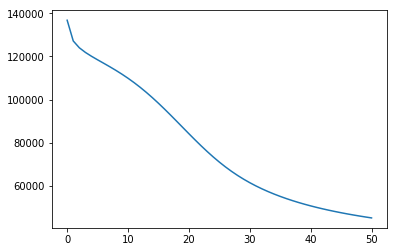

In [48]:
plt.plot(losses)

In [0]:
tt = np.random.randn(3,5)
dx = np.sum(tt, axis=0, keepdims=True)
dy = np.sum(tt, axis=0, keepdims=False)

In [51]:
dx, dy

(array([[-0.25790409,  1.27679487,  0.98308372,  0.74356223,  0.33177588]]),
 array([-0.25790409,  1.27679487,  0.98308372,  0.74356223,  0.33177588]))

In [54]:
dx.shape, dy.shape

((1, 5), (5,))